# Music Classification with Imbalanced Data

## Introduction

In this project, we use a music dataset, collected by a research group at [The Echo Nest](https://en.wikipedia.org/wiki/The_Echo_Nest) (now a part of [Spotify](https://en.wikipedia.org/wiki/Spotify)) to classify music genres without listening to the songs. This sort of classification, for example, allows for personalized song recommendations by streaming services. 

The dataset files, accompanied by this notebook, are the following:

- `"fma-rock-vs-hiphop.csv"`
- `"echonest-metrics.json"`

The dataset has musical features of each track such as `danceability` and `acousticness` on a scale from -1 to 1. We start by a few data preprocessing tasks followed by implementation of some of the scikit-learn's classification algorithms to predict whether we can correctly classify a song's genre based on features such as acousticness, energy, danceability, tempo, etc. 

Remarks: This project is an extended version of Datacamp's project on classifying song, available [here](https://www.datacamp.com/projects/449). I have avoided applying PCA in the following. 

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from google.colab import files
# import io
import time

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     cross_val_score, KFold,
                                     RepeatedStratifiedKFold)

# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils

## Basic Insight of Data

Let's first load the data which comes in two different formats:

- `csv` file including the music tracks metadata (title, artist, and number of listens) with genre `labels`
- `json` file including musical `features` of each track such as `danceability` and `acousticness`. 

We create two dataframes and merge them together so that we have features (X) and labels (y) in one dataframe.

In [2]:
# read in track metadata with genre labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")

# read in track metrics with the features
echonest_metrics = pd.read_json("echonest-metrics.json",
                                precise_float = True)

# merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(
                tracks[["track_id", "genre_top"]],
                on = "track_id")

print("The dataframe has {} data points and {} variables."
      .format(* echo_tracks.shape))

# inspect the dataframe
echo_tracks.head()

The dataframe has 4802 data points and 10 variables.


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [3]:
# inspect the datatypes
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


### A quick statistical summary

In [4]:
# get a quick statistical summary
echo_tracks.describe().round(2)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,4802.00,4802.00,4802.00,4802.00,4802.00,4802.00,4802.00,4802.00,4802.00
mean,30164.87,0.49,0.44,0.63,0.60,0.19,0.10,126.69,0.45
std,28592.01,0.37,0.18,0.24,0.38,0.15,0.15,34.00,0.27
min,2.00,0.00,0.05,0.00,0.00,0.03,0.02,29.09,0.01
25%,7494.25,0.08,0.30,0.45,0.16,0.10,0.04,98.00,0.22
50%,20723.50,0.52,0.42,0.65,0.81,0.12,0.05,124.63,0.45
75%,44240.75,0.86,0.57,0.84,0.92,0.22,0.09,151.45,0.67
max,124722.00,1.00,0.96,1.00,0.99,0.97,0.97,250.06,0.98


### Check for missing values

Let us check the dataframe for any missing values.

In [5]:
# any missing values?
echo_tracks.isnull().values.any()

False

### Inspect the target variable

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64


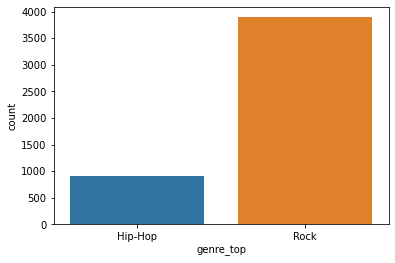

In [6]:
# inspect 'genre_top'
print(echo_tracks['genre_top'].value_counts())

sns.countplot(x=echo_tracks['genre_top'], data=echo_tracks )
plt.show()

So, we have an imbalanced data set, with 'Rock' class being the majority class and 'Hip-Hop' the minory class. Although, the data is not highly imbalanced, we will apply sampling techniques to our data to balance the dataset and check compare the performances of our algorithms.

## Data Preprocessing

We start by checking the correlation of continuous features. 

### Correlation matrix

In [7]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.format("{:.2f}").background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.00,-0.37,0.05,0.14,-0.28,0.05,-0.03,-0.03,0.01
acousticness,-0.37,1.00,-0.03,-0.28,0.19,-0.02,0.07,-0.03,-0.01
danceability,0.05,-0.03,1.00,-0.24,-0.26,-0.11,0.28,-0.24,0.47
energy,0.14,-0.28,-0.24,1.00,0.03,0.11,-0.11,0.20,0.04
instrumentalness,-0.28,0.19,-0.26,0.03,1.00,-0.09,-0.37,0.02,-0.22
liveness,0.05,-0.02,-0.11,0.11,-0.09,1.00,0.04,0.00,-0.05
speechiness,-0.03,0.07,0.28,-0.11,-0.37,0.04,1.00,0.01,0.15
tempo,-0.03,-0.03,-0.24,0.20,0.02,0.00,0.01,1.00,0.05
valence,0.01,-0.01,0.47,0.04,-0.22,-0.05,0.15,0.05,1.00


As we can see, there is no pair of highly correlated variables and we do not need to worry about multicolinearity effects. 

## Modeling

To begin with modelling, we first apply a few classifiers (with default hyperparameters) to our data and evaluate the performance of predictions. Then we balance our data using sampling techniques and select the best performing model.

**Remark on evaluation metric:** Usually, `accuracy score` is not a suitable measure of performance for (highly) imbalanced data. Although our data is not highly imbalanced and accuracy may not be a bad evaluation metric, we rely on `f1-score` and `roc-auc` for evaluating the performance of our algorithms. 

Let us first split our data and make a list of algorithms.

### Split data to train and test sets

In [8]:
# isolate features and the target
X = echo_tracks.drop(['track_id','genre_top'], axis = 1)
y = echo_tracks.loc[:, 'genre_top']

# split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2, random_state = 1)

print("Train Shape:", X_train.shape, 
      "\nTest Shape:", X_test.shape)

Train Shape: (3841, 8) 
Test Shape: (961, 8)


### Make a list of algorithms for modeling

In [9]:
# make a list of models with default hyperparameters
models = [
    # LogisticRegegression
    LogisticRegression(random_state=1),         
    # DecissionTree
    DecisionTreeClassifier(random_state=1),  
    # RandomForest 
    RandomForestClassifier(random_state=1),   
    # KNN
    KNeighborsClassifier(),  
    # Support Vector Machine
    SVC(),   
    # GradientBoosting
    GradientBoostingClassifier(random_state=1)  
         ]

### Modeling with imbalanced data

In [10]:
# define a function that makes a 
# pipeline for a given model
def imb_pipeline(model):
    steps = [('scaler', StandardScaler()),
             ('clf', model)
            ]
    pipeline = Pipeline(steps=steps)
    return pipeline

Let us compare the performance of our algorithms with imbalanced data and the default hyperparameter values.

In [11]:
for model in models:
    pipeline = imb_pipeline(model)
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    print(type(model).__name__, '\n', 
          classification_report(y_test, pred, digits=4))
    print("-"*10)

LogisticRegression 
               precision    recall  f1-score   support

     Hip-Hop     0.8652    0.5810    0.6952       210
        Rock     0.8927    0.9747    0.9319       751

    accuracy                         0.8887       961
   macro avg     0.8790    0.7778    0.8135       961
weighted avg     0.8867    0.8887    0.8802       961

----------
DecisionTreeClassifier 
               precision    recall  f1-score   support

     Hip-Hop     0.7650    0.7286    0.7463       210
        Rock     0.9251    0.9374    0.9312       751

    accuracy                         0.8918       961
   macro avg     0.8450    0.8330    0.8388       961
weighted avg     0.8901    0.8918    0.8908       961

----------
RandomForestClassifier 
               precision    recall  f1-score   support

     Hip-Hop     0.8876    0.7524    0.8144       210
        Rock     0.9336    0.9734    0.9531       751

    accuracy                         0.9251       961
   macro avg     0.9106    0.8629  

While all models perform well, with a weighted `f1-score` of over 88%, looking at our classification reports, we can see some bias towards rock songs. Indeed, our classifiers perform better in classifying rock songs mostly because we have far more data points for rock class with 751 data points than hip-hop with 210. As a result, accuracies in all models are represented by their ability to classify just rock songs, which is not ideal.

Because a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" and vice versa, we only need to account for differences in _sample size_ of our data points, not relative importance of each class. 


### Improving the performance

We may be able to improve the performance by:

- Balancing our data
- Tuning hyperparameters of the algorithms

We do both in the following. 

We balance our data by applying two sampling methods from `imblearn` library: 

- `RandomUnderSampler` (undersample the majority data) 
- `SMOTE` (oversample the minority data) 

In each sampling method, we also tune the hyperparameters of our algorithms using `GridSearchCV` with `RepeatedStratifiedKFold` cross-validation. 

**Remark**: the following limited list of numerical values for hyperparameters have been set after testing a longer list of values. This way we reduce the run time of the following codes.


In [12]:
# make a list of hyperparameters for the each of the above models
parameters = [
    {'model__C': [10, 15, 20, 70, 75],
     'model__penalty': ['l2'],
     'model__solver': ['lbfgs', 'liblinear']
    },    # param_LogReg
    
    {'model__criterion': ['gini', 'entropy'],
     'model__max_depth': [3, 4, 5, 6],
     'model__splitter': ['best', 'random']
    },  # param_Tree

    {'model__criterion' :['gini', 'entropy'],
     'model__max_depth' : [13, 14, 15],
     'model__max_features': ['auto', 'sqrt', 'log2'],
     'model__n_estimators': [400]
    },  # param_RandomForest
    
    {'model__algorithm': ['auto'], #, 'ball_tree', 'kd_tree', 'brute'],
     'model__metric': ['euclidean', 'manhattan', 'minkowski'],
     'model__n_neighbors': range(10, 40),
     'model__weights': ['uniform', 'distance']
    },   # param_KNN 
    
    {'model__C': [0, 1, 2, 3], 
     'model__gamma': ['scale', 'auto'],
     'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },  # param_SVC
    
    {'model__learning_rate': [0.085, 0.09, 0.095],
     'model__max_depth': [3, 5, 7],       
     'model__n_estimators': [400],
     'model__subsample': [3.0, 0.5]
    }  # param_GradientBoosting
      ]

### Improving the performance by hyperparameter tuning and undersampling

In [13]:
# define a function that makes a 
# undersampling pipeline for a given model 
def u_pipeline(model):
    under = RandomUnderSampler(
            random_state=1, 
            sampling_strategy='auto'
                              )
    steps = [('scaler', StandardScaler()),
             ('u', under), 
             ('model', model)
            ]
    pipeline = Pipeline(steps=steps)
    return pipeline

In [14]:
# initialize repeated stratified k-fold cross-validation
rkf = RepeatedStratifiedKFold(n_splits=10, 
                              n_repeats=3, 
                              random_state=1)

# capture start of running time
start = time.time()

# loop over models and hyperparameters for tuning
for model, grid in zip(models, parameters):
    # initialize GridSearchCV
    grid_search = GridSearchCV(
                   # undersampling pipeline
                   estimator=u_pipeline(model),
                   param_grid=grid,
                   n_jobs=-1,
                   cv=rkf, 
                   #scoring='accuracy',
                   scoring='roc_auc',
                   error_score=0)
    # fit GridSearchCV
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    message = "--{} \nBest Mean ROC AUC: {:.4f} \nwith: {}"
    print(message.format(type(model).__name__, 
                         grid_result.best_score_, 
                         grid_result.best_params_
                         )
         )

    print('-'*50)

# capture end of running time
end = time.time()

print("\nRun time (in minutes): {:.2f}".format((end-start)/60))

--LogisticRegression 
Best Mean ROC AUC: 0.9114 
with: {'model__C': 15, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
--------------------------------------------------
--DecisionTreeClassifier 
Best Mean ROC AUC: 0.9052 
with: {'model__criterion': 'entropy', 'model__max_depth': 4, 'model__splitter': 'best'}
--------------------------------------------------
--RandomForestClassifier 
Best Mean ROC AUC: 0.9534 
with: {'model__criterion': 'entropy', 'model__max_depth': 15, 'model__max_features': 'auto', 'model__n_estimators': 400}
--------------------------------------------------
--KNeighborsClassifier 
Best Mean ROC AUC: 0.9362 
with: {'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 17, 'model__weights': 'distance'}
--------------------------------------------------
--SVC 
Best Mean ROC AUC: 0.9444 
with: {'model__C': 2, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
--------------------------------------------------
--GradientBoostingClassifie

So, `RandomForestClassifier` does a better job of predicting genres, with mean `roc_auc` score of about 0.95. 

### Improving the performance by hyperparameter tuning and oversampling

In [15]:
# define a function that makes a SMOTE
# pipeline for a given model 
def o_pipeline(model):
    over = SMOTE(
            random_state=1, 
            sampling_strategy='auto'
                )
    
    steps = [('scaler', StandardScaler()),
             ('o', over), 
             ('model', model)
            ]
    pipeline = Pipeline(steps=steps)
    return pipeline

In [16]:
# initialize repeated stratified k-fold cross-validation
rkf = RepeatedStratifiedKFold(n_splits=10, 
                              n_repeats=3, 
                              random_state=1)

# capture time for running time
start = time.time()

# loop over models and hyperparameters for tuning
for model, grid in zip(models, parameters):
    # initialize GridSearchCV
    grid_search = GridSearchCV(
                   # oversampling pipeline
                   estimator=o_pipeline(model),
                   param_grid=grid,
                   n_jobs=-1,
                   cv=rkf, 
                   #scoring='accuracy',
                   scoring='roc_auc',
                   error_score=0)
    # fit GridSearchCV
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    message = "--{} \nBest Mean ROC AUC: {:.4f} \nwith: {}"
    print(message.format(type(model).__name__, 
                         grid_result.best_score_, 
                         grid_result.best_params_
                         )
         )

    print('-'*50)

# capture end of running time
end = time.time()

print("\nRun time (in minutes): {:.2f}".format((end-start)/60))

--LogisticRegression 
Best Mean ROC AUC: 0.9114 
with: {'model__C': 70, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
--------------------------------------------------
--DecisionTreeClassifier 
Best Mean ROC AUC: 0.9120 
with: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__splitter': 'best'}
--------------------------------------------------
--RandomForestClassifier 
Best Mean ROC AUC: 0.9569 
with: {'model__criterion': 'entropy', 'model__max_depth': 14, 'model__max_features': 'auto', 'model__n_estimators': 400}
--------------------------------------------------
--KNeighborsClassifier 
Best Mean ROC AUC: 0.9377 
with: {'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 39, 'model__weights': 'distance'}
--------------------------------------------------
--SVC 
Best Mean ROC AUC: 0.9449 
with: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
--------------------------------------------------
--GradientBoostingClassifie

Again, `RandomForestClassifier` does a better job of classifying genres. 

### Model selection

Overal, `RandomForestClassifier` and oversampling with `SMOTE` give higher cross-validation score, with the mean ROC AUC score of 0.9569.

In [17]:
# save the best model
best_model = RandomForestClassifier(
                criterion='entropy', 
                max_depth=14,
                max_features='auto',
                n_estimators=400,
                random_state=1)

In [18]:
# get predictions for the
# best performing model
pipeline = o_pipeline(best_model)
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

# get predictions
preds[0:5]

array(['Rock', 'Hip-Hop', 'Rock', 'Rock', 'Hip-Hop'], dtype=object)